# **C-calculate_onset_date.ipynb**

Author: Zhixian Yang

Email: [yangzhx28@mail2.sysu.edu.cn](mailto:yangzhx28@mail2.sysu.edu.cn) or [yimu01439@gmail.com](mailto:yimu01439@gmail.com)

GitHub: [https://github.com/koar-create](https://github.com/koar-create)

Date created: July 26th, 2023

Last modified: July 26th, 2023

<br><br>

---

<br><br>

## **Description**
This document is a Jupyter Notebook designed for an exercise derived from the "Computational Tools for Climate Science 2023" course offered by Climatematch Academy. The code presented here comprises a combination of materials provided in the course and code obtained from online sources.

# **<font color='red' size=5>0. download and import packages</font>**

In [1]:
import platform
if platform.system() == 'Linux':
    !pip install cdsapi --quiet
    !pip install imageio[ffmpeg] --quiet
    !pip install imageio[pyav] --quiet

In [2]:
# 1. downloaad
import cdsapi                         # download from Climate Data Store, ECMWF
import pooch, urllib.request          # download from any available URL
import s3fs, boto3, botocore          # download from S3 server, Amazon Web Service
from pythia_datasets import DATASETS  # download certain content from pythia

# 2. useful toolkits
from itertools import product
import os, sys, glob, time, tempfile

# 3. read and write
import h5py

# 4. data processing
from scipy import stats
from datetime import datetime, timedelta
import numpy as np, pandas as pd, xarray as xr

# 5. image processing
import imageio
import cartopy.io.shapereader as shapereader
import matplotlib as mpl, matplotlib.pyplot as plt
import cartopy, cartopy.crs as ccrs, cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [3]:
second_per_day = 86400

# **<font color='red' size=5>1. read data</font>**

## **<font size=5>1.1. precipitation</font>**

### **<font size=4>Yang: option 1 is the file `precip.mon.mean.nc` under the folder `shared/Data/Projects/ENSO` with time resolution of 1-month.</font>**

In [4]:
# # data source 1
# ds = xr.open_dataset('shared/Data/Projects/ENSO/precip.mon.mean.nc')
# ds

### **<font size=4>Yang: option 2 is the ERA5 ReAnalysis Data under the folder `Data/ERA5/monthly/single_level/1979_2023_SM.nc` with time resolution of 1-day.</font>**

In [5]:
file_path = os.path.join('Data', 'ERA5', 'hourly', 'single_level', '1979-2023_SH.nc')
ds = xr.open_dataset(file_path).squeeze()
ds

<xarray.Dataset>
Dimensions:    (longitude: 161, latitude: 101, time: 5350)
Coordinates:
  * longitude  (longitude) float32 90.0 90.25 90.5 90.75 ... 129.5 129.8 130.0
  * latitude   (latitude) float32 15.0 14.75 14.5 14.25 ... -9.5 -9.75 -10.0
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2023-02-28
Data variables:
    crr        (time, latitude, longitude) float32 ...
    lsrr       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-27 21:52:07 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### **<font size=4>Yang: option 3 is the TRMM precipitation Data under the folder `Data/TRMM/3B43/netcdf` with time resolution of 1-day.</font>**

In [8]:
# # # data source 4: TRMM
# mission = '3B42'
# idx = 0
# for year in range(2001, 2002 + 1):
#     version = '7' if ((year < 2000)|(year > 2010)) else '7A'
#     for month in range(1, 12 + 1):
#         for day in range(1, 31 + 1):
#             file_path = f'TRMM/{mission}/{year}/{month:02}/{day:02}/{mission}.{year}{month:02}{day:02}.00.{version}.HDF5'
#             if os.path.exists(file_path):
#                 with h5py.File(file_path, 'r') as hf:
#                     print(f"successfully open {file_path}")
#                     data = hf['/Grid/precipitation'][:].transpose()
#                 data = np.where(data <= 0.0, 0.0, data).reshape(1, data.shape[0], data.shape[1])
#                 da_temp = xr.DataArray(data, coords=[pd.date_range(f'{year}-{month:02}-{day:02}', periods=1), np.linspace(50, -50, data.shape[1]), np.linspace(0, 180, data.shape[2])], dims=['time', 'lat', 'lon'])
#                 da = xr.concat([da, da_temp], dim='time') if idx != 0 else da_temp
#                 idx += 1
# ds = xr.Dataset({'prcp': da})
# ds

## **<font size=5>1.2. landmask**

In [6]:
landmask = np.isnan(xr.open_dataset(os.path.join('Data', 'ERA5', 'monthly', 'single_level', '1979-2023_SM.nc')).sel(expver=1).isel(time=0).squeeze().sst).values
landmask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

# **<font color='red' size=5>2. calculate the onset date of monsoon</font>**

**<font size=4 face='Arial' color='002DE5'>The onset date is calculated from August 1st. It is the first day of the first 5-day sequence receiving at least 40 mm of rainfall, and within the following 30 days from that date, there should not be a dry 10-day sequence with a cumulative rainfall of less than 5 mm.</font>**

In [75]:
# prcp_series = np.array(
#     [
#         prcp.isel(time=i).values[landmask].mean() \
#         for i in range(len(prcp.time))
#     ]
# )

# LON, LAT = np.meshgrid(ds.longitude, ds.latitude)
# LON, LAT = LON[landmask], LAT[landmask]
# idx = sorted_indices[10]
# prcp_series = prcp.sel(longitude=LON[idx], latitude=LAT[idx]).squeeze()

# location_prcp_series = np.array([prcp.sel(longitude=LON[idx], latitude=LAT[idx]).squeeze().mean() for idx in range(len(LON))])
# sorted_indices = np.argsort(location_prcp_series)[::-1]
# sorted_indices[:10]

# print(LON[sorted_indices[20:30]], '\n', LAT[sorted_indices[20:30]])

# ax = plt.axes()
# ax.plot(prcp.time, prcp_series)
# ax.set_title(f"precipitation record at ({LON[idx]} E°, {LAT[idx]}°)")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

# plt.show()

In [7]:
def deg_suffix(deg, m='lon'):
    if m == 'lon':
        DEG = str(deg) + (' °W' if deg < 0 else (' °E' if deg > 0 else ''))
    elif m == 'lat':
        DEG = str(deg) + (' °S' if deg < 0 else (' °N' if deg > 0 else ''))
    else:
        DEG = str(deg)
    return DEG

In [87]:
def find_onset_date(ds, year=None, longitude=109, latitude=0):
    time_idx = ((ds.time.dt.year == year)&(ds.time.dt.month >= 11))|((ds.time.dt.year == year + 1)&(ds.time.dt.month <= 2))
    prcp = (ds.crr.sel(time=time_idx) + ds.lsrr.sel(time=time_idx)) * second_per_day
    prcp_series = prcp.sel(longitude=longitude, latitude=latitude, method='nearest').squeeze()
    
    # array used to find the onset date of monsoon
    larger_than_40mm = np.where(prcp_series < 40, 0, 1)
    less_than_5mm    = np.where(prcp_series >  5, 0, 1)

    ten_dry_days = np.zeros(prcp_series.shape)
    # some easy conditional operation
    for i in range(0, len(prcp_series)):
        if len(less_than_5mm[i:(i + 10)]) < 10:
            ten_dry_days[i] = np.nan
            continue
        if sum(less_than_5mm[i:(i + 10)]) == 10:
            ten_dry_days[i] = 1

    drought_signal = np.zeros(prcp_series.shape)
    # some easy conditional operation
    for i in range(0, len(prcp_series)):
        if len(ten_dry_days[i:(i + 30)]) < 30:
            drought_signal[i] = np.nan
            continue
        if sum(ten_dry_days[i:(i + 30)]) > 0:
            drought_signal[i] = 1
    
    monsoon_onset = np.zeros(prcp_series.shape)
    for idx in range(0, len(prcp_series)):
        if len(prcp_series[idx:(idx + 30)]) < 30:
            monsoon_onset[(idx + 1):] = np.nan
            break
        # print(f"date: {prcp_series.time.values[idx]}; larger than 40 mm: {larger_than_40mm[idx]==1}; drought: {drought_signal[idx]==1}")
        if (larger_than_40mm[idx] * (1 - drought_signal[idx])):
            monsoon_onset[idx] = 1
            monsoon_onset[(idx + 1):] = np.nan
            break
        else:
            monsoon_onset[idx] = np.nan

    onset_date = datetime.strptime(np.datetime_as_string(prcp_series.time.values[idx], unit='s'), '%Y-%m-%dT%H:%M:%S')
    normal_onset_date = datetime(year, 12, 10)
    day_delay = (onset_date - normal_onset_date).days
    # print(f"{onset_date.strftime('%Y-%m-%d')} is the onset date of monsoon this year. ")
    return day_delay, onset_date

In [88]:
# specify a location: (120.25°E, 3.5°S), and a time period (Nov, 1998 - Feb, 1999)
day_delay_list, onset_date_list = [], []

for year in range(1979, 2022 + 1):
    day_delay, onset_date = find_onset_date(ds, year=year, longitude=120.25, latitude=-3.50)
    day_delay_list.append(day_delay), onset_date_list.append(onset_date)
day_delay_array, onset_date_array = np.array(day_delay_list), np.array(onset_date_list)
da_day_delay  = xr.DataArray( day_delay_array, coords=[pd.date_range(start='1979', end='2022', freq='AS')], dims=['time'])
da_onset_date = xr.DataArray(onset_date_array, coords=[pd.date_range(start='1979', end='2022', freq='AS')], dims=['time'])

ds_onset = xr.Dataset({'delay': da_day_delay, 'onset_date': da_onset_date})
ds_onset

<xarray.Dataset>
Dimensions:     (time: 44)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2022-01-01
Data variables:
    delay       (time) int64 -12 -2 -22 2 -25 -15 -25 ... -16 -13 8 -15 -26 -10
    onset_date  (time) datetime64[ns] 1979-11-28 1980-12-08 ... 2022-11-30

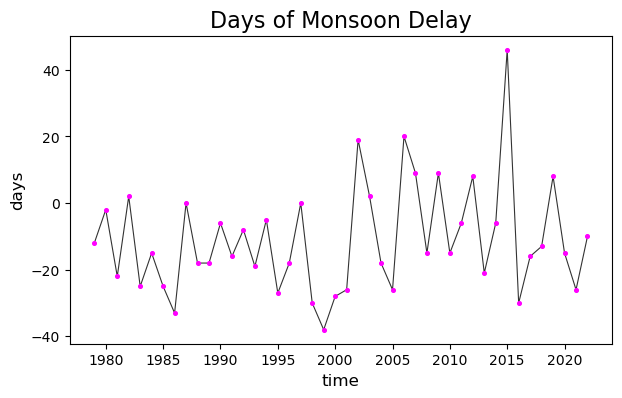

In [101]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(ds_onset.time, ds_onset.delay, linewidth=0.8, linestyle='solid', color='k', alpha=0.8, zorder=0)
ax.scatter(ds_onset.time, ds_onset.delay, s=7, marker='o', color='magenta', zorder=1)
ax.set_title('Days of Monsoon Delay', size=16)
ax.set_xlabel('time', size=12)
ax.set_ylabel('days', size=12)

plt.savefig(os.path.join('Figure', 'Days_of_Monsoon_Delay.png'), dpi=100)

plt.show()

### **<font size=5 color='blue'>some visualization</font>**

/tmp/ipykernel_43980/1208424223.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


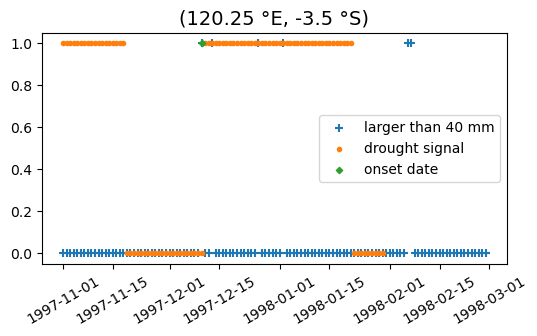

In [45]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(prcp_series.time, larger_than_40mm, marker='+', label='larger than 40 mm')
# ax.scatter(prcp_series.time, less_than_5mm   , marker='o', label='less than 5 mm')
# ax.scatter(prcp_series.time, ten_dry_days    , marker='^', label='ten dry days')
ax.scatter(prcp_series.time, drought_signal  , marker='.', label='drought signal')
ax.scatter(prcp_series.time, monsoon_onset   , marker='D', s=10, label='onset date')
ax.legend()
ax.set_title(f"({deg_suffix(longitude, 'lon')}, {deg_suffix(latitude, 'lat')})", size=14)

ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

plt.show()